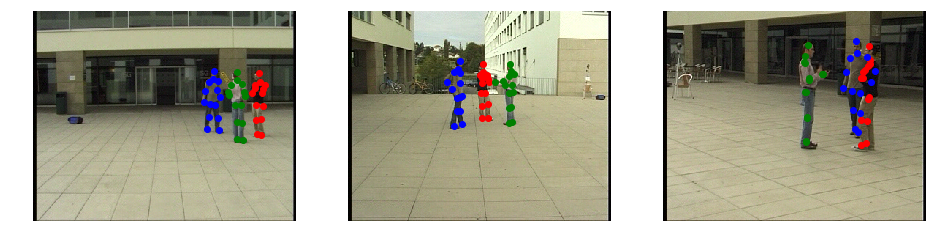

In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import epfl_campus

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

FRAME = 800
X, Y, Calib = epfl_campus.get(root, FRAME)

fig = plt.figure(figsize=(16,16))

COLORS = ['red', 'green', 'blue', 'yellow']

for cid in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, cid+1)
    cam = Calib[cid]
    im = X[cid]
    ax.imshow(im)
    ax.axis('off')
    
    for pid, person in enumerate(Y):
        pts3d = person
        if pts3d is None:
            continue
        
        pts2d = cam.projectPoints(pts3d)
        for u, v in pts2d:
            ax.scatter(u, v, color=COLORS[pid])

plt.show()

In [2]:
# ==================================
from mvpose import pose
from mvpose.algorithm import graphcut
from mvpose.algorithm.settings import get_settings
import paf_loader
from mvpose.plot.limbs import draw_mscoco_human

FRAME = 800
Im, Y, Calib = epfl_campus.get(root, FRAME)

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('campus', 
                                                        Im, 
                                                        FRAME, 
                                                        dir=tmp)

param = get_settings(scale_to_mm=1000)
Debug, detections = pose.estimate_heuristic(Calib, heatmaps, pafs,
                                  settings=param,
                                  debug=True)

print('\n# detections', len(detections))

/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


step 1: elapsed 0.3009319305419922
step 2: elapsed 0.012434720993041992
step 3: elapsed 0.1118779182434082
step 4: elapsed 0.2778472900390625
-------------------------------------------
Handle transitivity:
	Intra:		 22
	Intra(choice):	 18
	Inter:		 500
	Inter(choice):	 798
-------------------------------------------
	Time =  1091  ms
	result: 0

	Total cost: 3512.236834975701

# valid points:		 262
# invalid points:	 3
step 5: elapsed 1.1084649562835693
			valid views: # 3
			valid views: # 3
			valid views: # 2
			valid views: # 3
			valid views: # 3
			valid views: # 2
			valid views: # 2
			valid views: # 2
			valid views: # 3
			valid views: # 2
LEN BEFORE 10
LEN AFTER 10
step 7: elapsed 0.09761691093444824

# detections 0


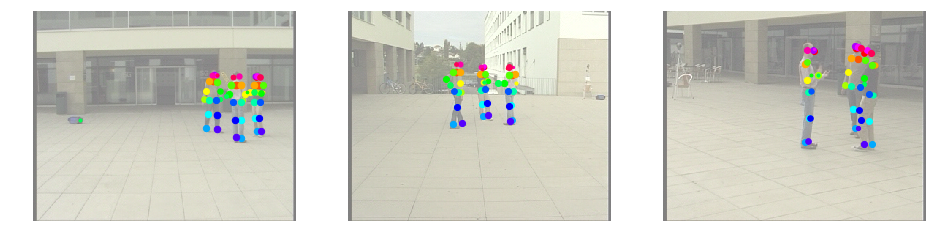

In [3]:
colors = cs.lincolor(19)/255
fig = plt.figure(figsize=(16,8))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    
    for jid in range(Debug.candidates2d.n_joints):
        for x,y,score in Debug.candidates2d.peaks2d_undistorted[cid][jid]:
            ax.scatter(x,y,s=score*50, c=colors[jid])
        
plt.show()

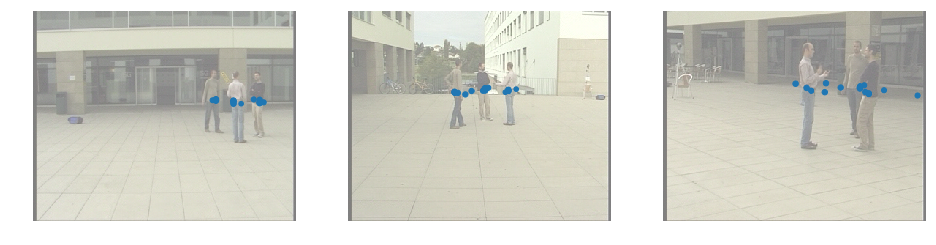

In [4]:
import mvpose.geometry as gm

JOINT = 11

pts3d_with_w = Debug.triangulation.peaks3d_weighted[JOINT]
pts3d = pts3d_with_w[:,0:3].astype('float32')


fig = plt.figure(figsize=(16,12))
for cid, (im, cam) in enumerate(zip(Im, Calib)):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    pts2d = cam.projectPoints_undist(pts3d)
    ax.scatter(pts2d[:,0], pts2d[:,1], 
               s=pts3d_with_w[:,3] * pts3d_with_w[:,4] * 50)
    
plt.show()

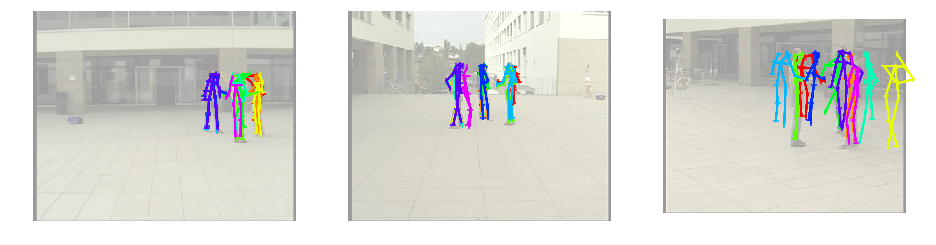

In [5]:
from mvpose.algorithm.candidate_selection import project_human_to_2d

Humans = Debug.graphcut.person_candidates


fig = plt.figure(figsize=(16,12))

colors = cs.lincolor(len(Humans) + 2) / 255

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
    
plt.show()